In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time

In [2]:
plt.style.use('dark_background')

In [3]:
#!pip install celluloid

In [4]:
import celluloid

Research question: how important is free throw differential? The Bucks are last in free throws made, and 5th highest in free throws given up, about a 7 point difference. how much does having a negative/positive differential affect winning?

# Data Collection
get opponent free throws made from: https://www.nba.com/stats/teams/opponent?dir=D&sort=OPP_FTM

get free throws made from: https://www.nba.com/stats/teams/traditional?dir=A&sort=FTM

opponent stats url:
https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&ISTRound=&LastNGames=0&LeagueID=00&Location=&MeasureType=Opponent&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2025-26&SeasonSegment=&SeasonType=Regular Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=

own stats url:
GET
	https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&ISTRound=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2025-26&SeasonSegment=&SeasonType=Regular Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=

In [47]:
## FIXME: generalize this function for various NBA dashboards, to grab both of the above

def opponent_url():

    return "https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=" + \
                    "&GameSegment=&Height=&ISTRound=&LastNGames=0&LeagueID=00&Location=&MeasureType=Opponent&Month=0&OpponentTeamID=0" + \
                    "&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N" + \
                    "&Season=%(season)s&SeasonSegment=&SeasonType=Regular Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision="

    # the_url = url_template % {'season' : season}
    # return the_url

def own_url():
    return "https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&ISTRound=" +\
        "&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0" +\
        "&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=%(season)s&SeasonSegment=&SeasonType=Regular Season&ShotClockRange=&StarterBench=" +\
        "&TeamID=0&TwoWay=0&VsConference=&VsDivision="


def misc_url():
    ## this is for second chance points, etc.
    # https://www.nba.com/stats/teams/misc?dir=D&sort=PTS_2ND_CHANCE
    return "https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&ISTRound=" +\
            "&LastNGames=0&LeagueID=00&Location=&MeasureType=Misc&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=" +\
            "&PlayerPosition=&PlusMinus=N&Rank=N&Season=%(season)s&SeasonSegment=&SeasonType=Regular Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision="


In [49]:
## FIXME: these are copy-pasted from another notebook...I should put it in its own library

headers = {
    'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:145.0) Gecko/20100101 Firefox/145.0",
    'Referer' : "https://www.nba.com",
    'Origin'  : "https://www.nba.com",
    "Sec-GPC" : "1",
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-site"
}



def get_data_for_season(season="2025-26"):
    # get own data
    url = own_url() % {'season' : season}
    r = requests.get(url, headers=headers)
    req_json =  r.json()['resultSets'][0]
    df = pd.DataFrame(req_json['rowSet'], columns=req_json['headers'])
    own_data = df.set_index("TEAM_NAME")

    # get opponent data
    url = opponent_url() % {'season' : season}
    r = requests.get(url, headers=headers)
    req_json =  r.json()['resultSets'][0]
    df = pd.DataFrame(req_json['rowSet'], columns=req_json['headers'])
    opponent_data = df.set_index("TEAM_NAME")

    # get misc data
    url = misc_url() % {'season' : season}
    r = requests.get(url, headers=headers)
    req_json =  r.json()['resultSets'][0]
    df = pd.DataFrame(req_json['rowSet'], columns=req_json['headers'])
    misc_data = df.set_index("TEAM_NAME")

    # find and nuke potential duplicate columns
    # from https://www.geeksforgeeks.org/python/prevent-duplicated-columns-when-joining-two-pandas-dataframes/
    different_cols = own_data.columns.difference(opponent_data.columns)
    own_unique = own_data[different_cols].copy()

    diff2 = misc_data.columns.difference(opponent_data.columns)
    misc_unique = misc_data[diff2].copy()

    # merge them

    return pd.concat([opponent_data, own_unique, misc_unique], axis=1)
    


In [50]:
goo = get_data_for_season()

In [51]:
goo

,TEAM_ID,GP,W,L,W_PCT,MIN,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,...,OPP_PTS_PAINT,OPP_PTS_PAINT_RANK,PTS_2ND_CHANCE,PTS_2ND_CHANCE_RANK,PTS_FB,PTS_FB_RANK,PTS_OFF_TOV,PTS_OFF_TOV_RANK,PTS_PAINT,PTS_PAINT_RANK
TEAM_NAME,,,,,,,,,,,,,,,,,,,,,
Atlanta Hawks,1610612737,25,14,11,0.560,48.4,41.8,89.3,0.469,12.9,...,51.5,19,13.8,25,18.2,4,21.4,4,53.1,8
Boston Celtics,1610612738,24,15,9,0.625,48.0,37.9,85.1,0.446,13.6,...,41.7,2,17.5,3,14.5,17,19.3,8,43.3,28
Brooklyn Nets,1610612751,23,6,17,0.261,48.0,42.6,86.0,0.495,13.2,...,53.5,25,15.0,16,10.5,30,16.7,25,41.7,29
Charlotte Hornets,1610612766,24,7,17,0.292,48.4,44.3,90.1,0.492,13.5,...,53.7,26,15.9,11,11.2,29,15.1,29,49.2,17
Chicago Bulls,1610612741,23,9,14,0.391,48.4,44.6,93.7,0.475,13.7,...,53.9,27,13.5,27,17.7,5,17.0,23,53.2,7
Cleveland Cavaliers,1610612739,25,14,11,0.560,48.2,40.5,87.8,0.462,12.9,...,48.3,9,16.1,10,15.8,10,20.1,5,47.9,23
Dallas Mavericks,1610612742,25,9,16,0.360,48.6,42.6,92.2,0.461,11.1,...,55.6,30,12.6,29,17.6,6,16.6,26,49.0,20
Denver Nuggets,1610612743,23,17,6,0.739,48.2,42.2,90.6,0.465,13.1,...,48.6,11,15.8,12,15.7,12,15.1,28,52.9,9
Detroit Pistons,1610612765,24,19,5,0.792,48.2,38.4,86.2,0.446,13.4,...,44.0,3,17.2,6,16.5,8,21.6,3,57.1,1


In [53]:
list(goo.columns)

['TEAM_ID',
 'GP',
 'W',
 'L',
 'W_PCT',
 'MIN',
 'OPP_FGM',
 'OPP_FGA',
 'OPP_FG_PCT',
 'OPP_FG3M',
 'OPP_FG3A',
 'OPP_FG3_PCT',
 'OPP_FTM',
 'OPP_FTA',
 'OPP_FT_PCT',
 'OPP_OREB',
 'OPP_DREB',
 'OPP_REB',
 'OPP_AST',
 'OPP_TOV',
 'OPP_STL',
 'OPP_BLK',
 'OPP_BLKA',
 'OPP_PF',
 'OPP_PFD',
 'OPP_PTS',
 'PLUS_MINUS',
 'GP_RANK',
 'W_RANK',
 'L_RANK',
 'W_PCT_RANK',
 'MIN_RANK',
 'OPP_FGM_RANK',
 'OPP_FGA_RANK',
 'OPP_FG_PCT_RANK',
 'OPP_FG3M_RANK',
 'OPP_FG3A_RANK',
 'OPP_FG3_PCT_RANK',
 'OPP_FTM_RANK',
 'OPP_FTA_RANK',
 'OPP_FT_PCT_RANK',
 'OPP_OREB_RANK',
 'OPP_DREB_RANK',
 'OPP_REB_RANK',
 'OPP_AST_RANK',
 'OPP_TOV_RANK',
 'OPP_STL_RANK',
 'OPP_BLK_RANK',
 'OPP_BLKA_RANK',
 'OPP_PF_RANK',
 'OPP_PFD_RANK',
 'OPP_PTS_RANK',
 'PLUS_MINUS_RANK',
 'AST',
 'AST_RANK',
 'BLK',
 'BLKA',
 'BLKA_RANK',
 'BLK_RANK',
 'DREB',
 'DREB_RANK',
 'FG3A',
 'FG3A_RANK',
 'FG3M',
 'FG3M_RANK',
 'FG3_PCT',
 'FG3_PCT_RANK',
 'FGA',
 'FGA_RANK',
 'FGM',
 'FGM_RANK',
 'FG_PCT',
 'FG_PCT_RANK',
 'FTA',
 'FTA_

In [7]:
def fetch_seasons(start_year=15, end_year=26):
    years = [x for x in range(start_year, end_year)]

    dataframes = []
    for year in years:
        year_param = "20%02d-%02d" % (year, year+1)
        df = get_data_for_season(year_param)
        df['SEASON'] = year
        dataframes.append(df)
        print(f"did {year_param}")
        time.sleep(2)

    df = pd.concat(dataframes)
    return df
    

they have this data all the way back to 2001, which is cool

In [ ]:
# all_data = fetch_seasons(1, 26)
# all_data.to_parquet("free-throws-2001-2025.parquet")

did 2001-02
did 2002-03
did 2003-04
did 2004-05
did 2005-06
did 2006-07
did 2007-08
did 2008-09
did 2009-10
did 2010-11
did 2011-12
did 2012-13
did 2013-14
did 2014-15
did 2015-16
did 2016-17
did 2017-18
did 2018-19
did 2019-20
did 2020-21
did 2021-22
did 2022-23
did 2023-24
did 2024-25
did 2025-26


In [ ]:
all_data = pd.read_parquet("free-throws-2001-2025.parquet")

# Exploration/Analysis

pretty strong correlation between opponent free throws made, and number of wins

In [10]:
all_data.W_RANK.corr(all_data.OPP_FTM)

np.float64(0.25948820428026864)

Text(0.5, 0, 'opponent free throws')

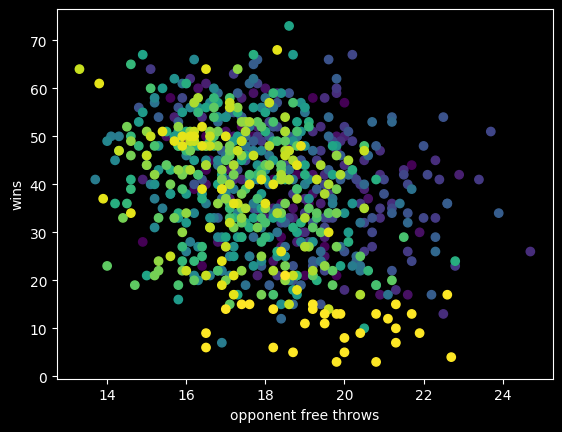

In [11]:
plt.scatter(all_data.OPP_FTM, all_data.W, c=all_data.SEASON)
plt.ylabel("wins")
plt.xlabel("opponent free throws")

I'll add an attribute for free throw differential. 

Comparisons should probably be versus win percentage, not raw wins, due to some short seasons (eg 2021)

In [12]:
all_data['FTM_DIFF'] = all_data.FTM - all_data.OPP_FTM

In [13]:
all_data.W_PCT.corr(all_data.FTM_DIFF)

np.float64(0.3695559416232997)

In [14]:
all_data.W_PCT.corr(all_data.FTM)

np.float64(0.15335430567166797)

In [15]:
all_data.W_PCT.corr(all_data.OPP_FTM)

np.float64(-0.2597676432166427)

In [16]:
all_data.FTM.corr(all_data.OPP_FTM)

np.float64(0.37908926532177195)

In [17]:
all_data.iloc[15, :]

AST                22.5
AST_RANK           10.0
BLK                 4.7
BLKA                4.4
BLKA_RANK           4.0
                   ... 
OPP_PFD_RANK       10.0
OPP_PTS_RANK       22.0
PLUS_MINUS_RANK    16.0
SEASON              1.0
FTM_DIFF           -2.1
Name: Milwaukee Bucks, Length: 95, dtype: float64

In [18]:
all_data[all_data.SEASON == 25].FTM_DIFF.describe()

count    30.000000
mean      0.043333
std       3.121083
min      -6.900000
25%      -2.150000
50%       0.450000
75%       2.100000
max       5.400000
Name: FTM_DIFF, dtype: float64

In [19]:
all_data.FTM_DIFF.describe()

count    7.470000e+02
mean     1.093874e-16
std      2.121775e+00
min     -6.900000e+00
25%     -1.400000e+00
50%      0.000000e+00
75%      1.500000e+00
max      6.600000e+00
Name: FTM_DIFF, dtype: float64

In [ ]:
all_data.colum

Text(0, 0.5, 'FT differential')

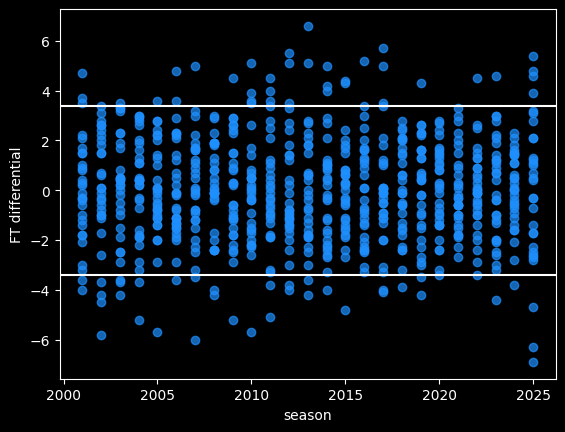

In [20]:
plt.scatter(2000 + all_data.SEASON, all_data.FTM_DIFF, color='dodgerblue', alpha=.7)
plt.axhline(all_data.FTM_DIFF.quantile(.95), color='white')
plt.axhline(all_data.FTM_DIFF.quantile(.05), color='white')
#plt.title("free throw point differential by season")
plt.xlabel("season")
plt.ylabel("FT differential")


who's that other outlier in 2025 besides the Bucks?

In [21]:
print(all_data.loc[all_data.SEASON == 25, ['FTM_DIFF']].sort_values(by='FTM_DIFF').to_markdown())

| TEAM_NAME              |   FTM_DIFF |
|:-----------------------|-----------:|
| Milwaukee Bucks        |       -6.9 |
| Boston Celtics         |       -6.3 |
| Washington Wizards     |       -4.7 |
| Sacramento Kings       |       -2.8 |
| Cleveland Cavaliers    |       -2.7 |
| Phoenix Suns           |       -2.6 |
| Atlanta Hawks          |       -2.5 |
| Toronto Raptors        |       -2.3 |
| Detroit Pistons        |       -1.7 |
| Indiana Pacers         |       -1.7 |
| Chicago Bulls          |       -1.4 |
| Minnesota Timberwolves |       -0.7 |
| Dallas Mavericks       |       -0.3 |
| New Orleans Pelicans   |       -0.3 |
| Golden State Warriors  |        0.4 |
| New York Knicks        |        0.5 |
| Portland Trail Blazers |        0.7 |
| Brooklyn Nets          |        1   |
| Philadelphia 76ers     |        1.1 |
| Miami Heat             |        1.2 |
| Utah Jazz              |        1.3 |
| LA Clippers            |        2.1 |
| Denver Nuggets         |        2.1 |


plot free throw differential versus win percentage

In [22]:
all_data.columns

Index(['AST', 'AST_RANK', 'BLK', 'BLKA', 'BLKA_RANK', 'BLK_RANK', 'DREB',
       'DREB_RANK', 'FG3A', 'FG3A_RANK', 'FG3M', 'FG3M_RANK', 'FG3_PCT',
       'FG3_PCT_RANK', 'FGA', 'FGA_RANK', 'FGM', 'FGM_RANK', 'FG_PCT',
       'FG_PCT_RANK', 'FTA', 'FTA_RANK', 'FTM', 'FTM_RANK', 'FT_PCT',
       'FT_PCT_RANK', 'OREB', 'OREB_RANK', 'PF', 'PFD', 'PFD_RANK', 'PF_RANK',
       'PTS', 'PTS_RANK', 'REB', 'REB_RANK', 'STL', 'STL_RANK', 'TOV',
       'TOV_RANK', 'TEAM_ID', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'OPP_FGM',
       'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A', 'OPP_FG3_PCT',
       'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB', 'OPP_DREB', 'OPP_REB',
       'OPP_AST', 'OPP_TOV', 'OPP_STL', 'OPP_BLK', 'OPP_BLKA', 'OPP_PF',
       'OPP_PFD', 'OPP_PTS', 'PLUS_MINUS', 'GP_RANK', 'W_RANK', 'L_RANK',
       'W_PCT_RANK', 'MIN_RANK', 'OPP_FGM_RANK', 'OPP_FGA_RANK',
       'OPP_FG_PCT_RANK', 'OPP_FG3M_RANK', 'OPP_FG3A_RANK', 'OPP_FG3_PCT_RANK',
       'OPP_FTM_RANK', 'OPP_FTA_RANK', 'OPP_FT_P

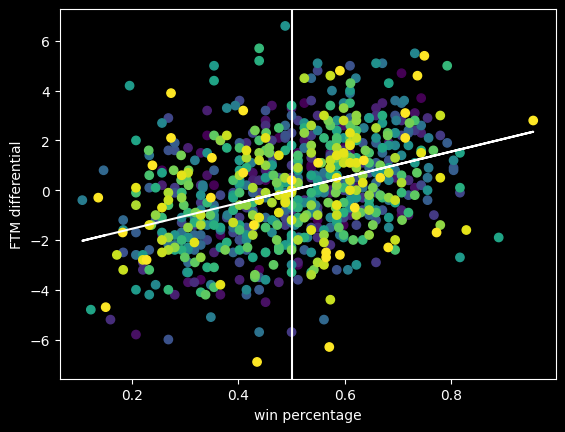

In [23]:
plt.scatter(all_data.W_PCT, all_data.FTM_DIFF, c=all_data.SEASON)
plt.xlabel("win percentage")
plt.ylabel("FTM differential")
plt.axvline(.5)

## add trendline
trend_fit = np.polyfit(all_data.W_PCT, all_data.FTM_DIFF, 1)
trend_line = np.poly1d(trend_fit)
plt.plot(all_data.W_PCT, trend_line(all_data.W_PCT), color='white')

the correlation is weaker with a team's own number of free throws made.

blocks are interesting, they matter more than I would think

blocks against is way more important than blocks for

In [24]:
all_data.W_PCT.corr(all_data.OPP_BLK)

np.float64(-0.46089180645758965)

there is some correlation between getting a lot of free throws, and giving up a lot of them.

I think this is because it's seasonal data. The base rate of number of free throws called goes up and down season-to-season, so the numbers should be a bit correlated with each other.

In [25]:
all_data.FTM.corr(all_data.OPP_FTM)

np.float64(0.37908926532177195)

In [26]:
all_data.SEASON.value_counts()

SEASON
5     30
8     30
4     30
7     30
6     30
9     30
12    30
11    30
10    30
18    30
19    30
20    30
13    30
14    30
15    30
16    30
17    30
22    30
23    30
24    30
21    30
25    30
3     29
1     29
2     29
Name: count, dtype: int64

# Evolution of free throw rates
How have free throw rates changed over time?

An animated scatterplot (by season) would be cool.

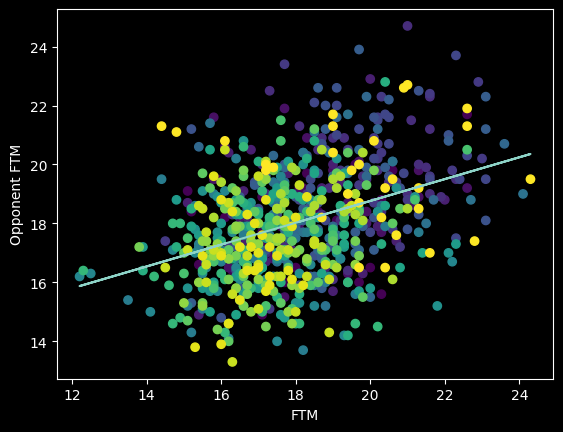

In [27]:
plt.scatter(all_data.FTM, all_data.OPP_FTM, c=all_data.SEASON)
plt.xlabel("FTM")
plt.ylabel("Opponent FTM")

## add yearly trendline
trend_fit = np.polyfit(all_data.FTM, all_data.OPP_FTM, 1)
trend_line = np.poly1d(trend_fit)
plt.plot(all_data.FTM, trend_line(all_data.FTM))

do animated 

MovieWriter ffmpeg unavailable; using Pillow instead.


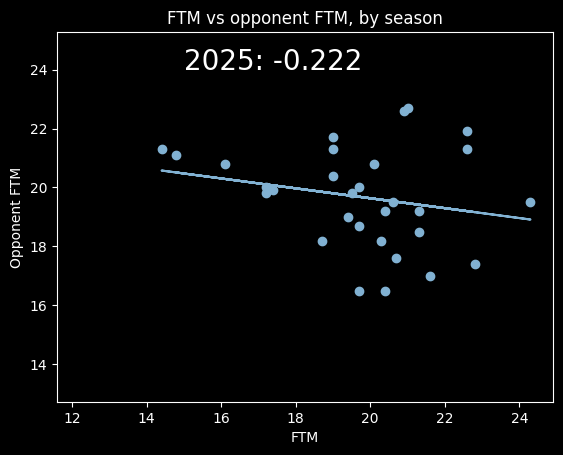

In [28]:
from celluloid import Camera


fig, ax = plt.subplots()

cam = Camera(fig)

corr_by_season = []

for season in all_data.SEASON.unique():
    this_season = all_data[all_data.SEASON == season]
    t = ax.scatter(this_season.FTM, this_season.OPP_FTM, label=season)
    this_corr = this_season.FTM.corr(this_season.OPP_FTM)
    corr_by_season.append(this_corr)

    ax.text(15, 24, "20%02d: %.3f" % (season, this_corr), size=20)
    ax.set_xlabel("FTM")
    ax.set_ylabel("Opponent FTM")
    
    ## add yearly trendline
    trend_fit = np.polyfit(this_season.FTM, this_season.OPP_FTM, 1)
    trend_line = np.poly1d(trend_fit)
    plt.plot(this_season.FTM, trend_line(this_season.FTM))

    cam.snap()

ax.set_title("FTM vs opponent FTM, by season")

anim = cam.animate()
anim.save("ftm_scatter.gif", fps=1)
plt.show()

TODO: a chart of correlation by season

Text(0.5, 1.0, 'correlation - FTM vs opponent FTM')

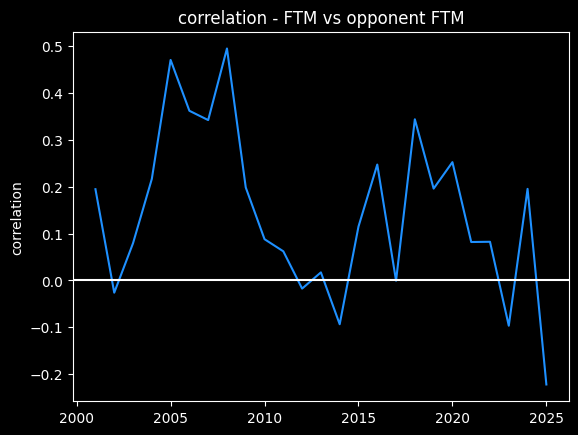

In [29]:
plt.plot(range(2001, 2026), corr_by_season, color='dodgerblue')
plt.axhline(0)
plt.ylabel("correlation")
plt.title("correlation - FTM vs opponent FTM")

MovieWriter ffmpeg unavailable; using Pillow instead.


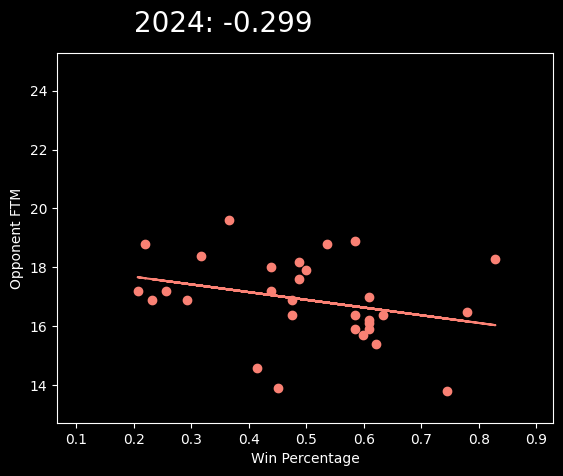

In [30]:
from celluloid import Camera


fig, ax = plt.subplots()

cam = Camera(fig)

for season in all_data.SEASON.unique():
    # skip 2025 for this one
    if season == 25:
        continue
    this_season = all_data[all_data.SEASON == season]
    t = ax.scatter(this_season.W_PCT, this_season.OPP_FTM, label=season)
    this_corr = this_season.W_PCT.corr(this_season.OPP_FTM)
    ax.text(.2, 26, "20%02d: %.3f" % (season, this_corr), size=20)
    ax.set_xlabel("Win Percentage")
    ax.set_ylabel("Opponent FTM")
    
    ## add yearly trendline
    trend_fit = np.polyfit(this_season.W_PCT, this_season.OPP_FTM, 1)
    trend_line = np.poly1d(trend_fit)
    plt.plot(this_season.W_PCT, trend_line(this_season.W_PCT))

    cam.snap()

anim = cam.animate()
anim.save("w_opponent_scatter.gif", fps=1)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


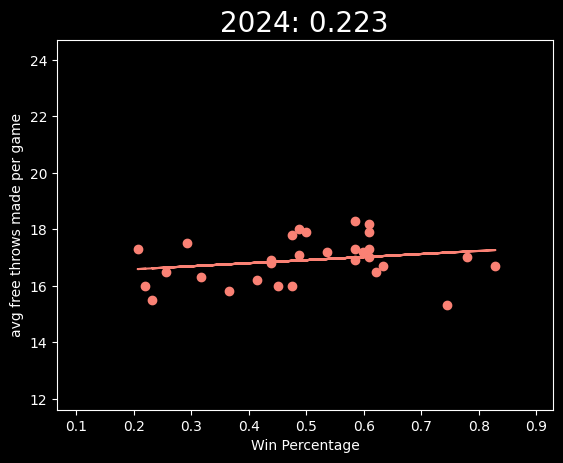

In [31]:
from celluloid import Camera

## own team free throws

fig, ax = plt.subplots()

cam = Camera(fig)

for season in all_data.SEASON.unique():
    # skip 2025 for this one
    if season == 25:
        continue
    this_season = all_data[all_data.SEASON == season]
    t = ax.scatter(this_season.W_PCT, this_season.FTM, label=season)
    this_corr = this_season.W_PCT.corr(this_season.FTM)
    ax.text(.35, 25, "20%02d: %.3f" % (season, this_corr), size=20)
    ax.set_xlabel("Win Percentage")
    ax.set_ylabel("avg free throws made per game")
    
    ## add yearly trendline
    trend_fit = np.polyfit(this_season.W_PCT, this_season.FTM, 1)
    trend_line = np.poly1d(trend_fit)
    plt.plot(this_season.W_PCT, trend_line(this_season.W_PCT))

    cam.snap()

anim = cam.animate()
anim.save("w_scatter.gif", fps=1)
plt.show()

## Free throw trends over the past 25 years

plot number of average  free throws made by year

Text(0.5, 1.0, 'made free throws per game')

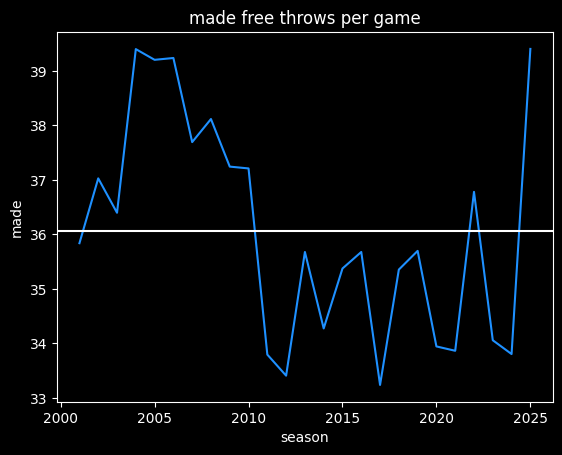

In [32]:
total_freethrows_made = all_data.groupby("SEASON")['FTM'].mean() + all_data.groupby("SEASON")['OPP_FTM'].mean() 

plt.plot(2000 + total_freethrows_made.index, total_freethrows_made , color='dodgerblue')
plt.axhline(np.mean(total_freethrows_made))
#plt.axvline(2010)
#plt.title('avg free throws per game')
plt.xlabel("season")
plt.ylabel("made")
plt.title("made free throws per game")

#_out = plt.grid()

In [38]:
all_data.columns

Index(['AST', 'AST_RANK', 'BLK', 'BLKA', 'BLKA_RANK', 'BLK_RANK', 'DREB',
       'DREB_RANK', 'FG3A', 'FG3A_RANK', 'FG3M', 'FG3M_RANK', 'FG3_PCT',
       'FG3_PCT_RANK', 'FGA', 'FGA_RANK', 'FGM', 'FGM_RANK', 'FG_PCT',
       'FG_PCT_RANK', 'FTA', 'FTA_RANK', 'FTM', 'FTM_RANK', 'FT_PCT',
       'FT_PCT_RANK', 'OREB', 'OREB_RANK', 'PF', 'PFD', 'PFD_RANK', 'PF_RANK',
       'PTS', 'PTS_RANK', 'REB', 'REB_RANK', 'STL', 'STL_RANK', 'TOV',
       'TOV_RANK', 'TEAM_ID', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'OPP_FGM',
       'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A', 'OPP_FG3_PCT',
       'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB', 'OPP_DREB', 'OPP_REB',
       'OPP_AST', 'OPP_TOV', 'OPP_STL', 'OPP_BLK', 'OPP_BLKA', 'OPP_PF',
       'OPP_PFD', 'OPP_PTS', 'PLUS_MINUS', 'GP_RANK', 'W_RANK', 'L_RANK',
       'W_PCT_RANK', 'MIN_RANK', 'OPP_FGM_RANK', 'OPP_FGA_RANK',
       'OPP_FG_PCT_RANK', 'OPP_FG3M_RANK', 'OPP_FG3A_RANK', 'OPP_FG3_PCT_RANK',
       'OPP_FTM_RANK', 'OPP_FTA_RANK', 'OPP_FT_P

what does made free throws as a percentage of points look like?

In [39]:
all_data['FT_TO_POINTS'] = all_data.FTM / all_data.PTS

In [42]:
ft_to_points = all_data.groupby("SEASON")['FT_TO_POINTS'].mean()


Text(0.5, 1.0, 'percent of points off of free throws')

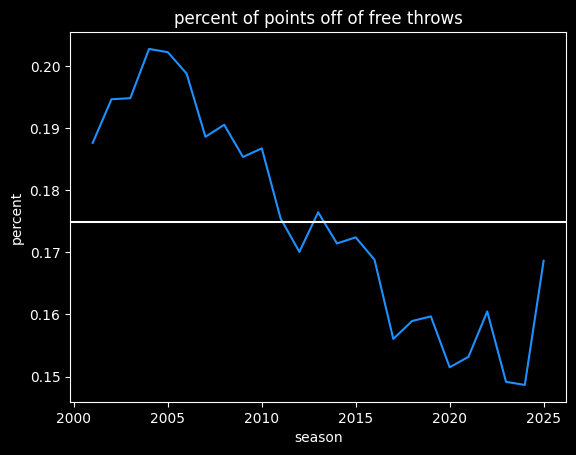

In [44]:


plt.plot(2000 + ft_to_points.index, ft_to_points , color='dodgerblue')
plt.axhline(np.mean(ft_to_points))
#plt.axvline(2010)
#plt.title('avg free throws per game')
plt.xlabel("season")
plt.ylabel("percent")
plt.title("percent of points off of free throws")

## What about 2nd chance point differential?

Does it matter?

In [56]:
list(all_data.columns)

['TEAM_ID',
 'GP',
 'W',
 'L',
 'W_PCT',
 'MIN',
 'OPP_FGM',
 'OPP_FGA',
 'OPP_FG_PCT',
 'OPP_FG3M',
 'OPP_FG3A',
 'OPP_FG3_PCT',
 'OPP_FTM',
 'OPP_FTA',
 'OPP_FT_PCT',
 'OPP_OREB',
 'OPP_DREB',
 'OPP_REB',
 'OPP_AST',
 'OPP_TOV',
 'OPP_STL',
 'OPP_BLK',
 'OPP_BLKA',
 'OPP_PF',
 'OPP_PFD',
 'OPP_PTS',
 'PLUS_MINUS',
 'GP_RANK',
 'W_RANK',
 'L_RANK',
 'W_PCT_RANK',
 'MIN_RANK',
 'OPP_FGM_RANK',
 'OPP_FGA_RANK',
 'OPP_FG_PCT_RANK',
 'OPP_FG3M_RANK',
 'OPP_FG3A_RANK',
 'OPP_FG3_PCT_RANK',
 'OPP_FTM_RANK',
 'OPP_FTA_RANK',
 'OPP_FT_PCT_RANK',
 'OPP_OREB_RANK',
 'OPP_DREB_RANK',
 'OPP_REB_RANK',
 'OPP_AST_RANK',
 'OPP_TOV_RANK',
 'OPP_STL_RANK',
 'OPP_BLK_RANK',
 'OPP_BLKA_RANK',
 'OPP_PF_RANK',
 'OPP_PFD_RANK',
 'OPP_PTS_RANK',
 'PLUS_MINUS_RANK',
 'AST',
 'AST_RANK',
 'BLK',
 'BLKA',
 'BLKA_RANK',
 'BLK_RANK',
 'DREB',
 'DREB_RANK',
 'FG3A',
 'FG3A_RANK',
 'FG3M',
 'FG3M_RANK',
 'FG3_PCT',
 'FG3_PCT_RANK',
 'FGA',
 'FGA_RANK',
 'FGM',
 'FGM_RANK',
 'FG_PCT',
 'FG_PCT_RANK',
 'FTA',
 'FTA_

In [57]:
all_data['PTS_2ND_DIFF'] = all_data.PTS_2ND_CHANCE - all_data.OPP_PTS_2ND_CHANCE

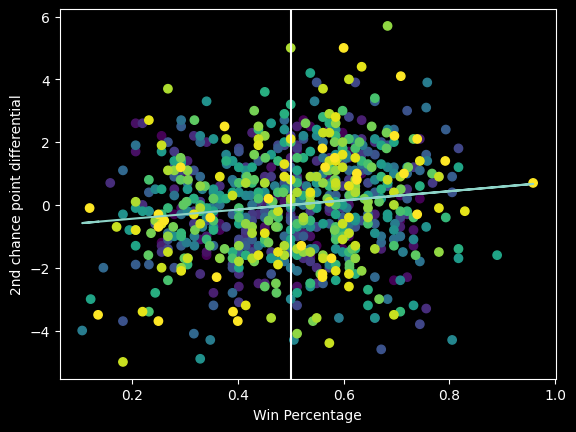

In [64]:
plt.scatter(all_data.W_PCT, all_data.PTS_2ND_DIFF, c=all_data.SEASON)
plt.xlabel("Win Percentage")
plt.ylabel("2nd chance point differential")

## add yearly trendline
trend_fit = np.polyfit(all_data.W_PCT, all_data.PTS_2ND_DIFF, 1)
trend_line = np.poly1d(trend_fit)
plt.plot(all_data.W_PCT, trend_line(all_data.W_PCT))

plt.axvline(.5)

In [63]:
all_data.W_PCT.corr(all_data.PTS_2ND_DIFF)

np.float64(0.13246656810233962)

## What about the lakers?

this probably won't make it into the blog

In [34]:
all_data

,AST,AST_RANK,BLK,BLKA,BLKA_RANK,BLK_RANK,DREB,DREB_RANK,FG3A,FG3A_RANK,...,OPP_TOV_RANK,OPP_STL_RANK,OPP_BLK_RANK,OPP_BLKA_RANK,OPP_PF_RANK,OPP_PFD_RANK,OPP_PTS_RANK,PLUS_MINUS_RANK,SEASON,FTM_DIFF
TEAM_NAME,,,,,,,,,,,,,,,,,,,,,
Atlanta Hawks,20.2,26,4.3,6.2,26,27,29.8,17,14.6,14,...,10,26,26,27,7,20,25,24,1,0.3
Boston Celtics,21.0,20,3.6,5.8,25,28,31.3,3,23.7,1,...,2,13,25,28,17,12,9,9,1,-1.4
Charlotte Hornets,21.5,19,5.6,5.1,16,12,30.5,12,12.1,23,...,21,14,16,12,13,16,7,13,1,1.0
Chicago Bulls,22.2,12,4.4,4.9,10,25,28.8,25,10.6,26,...,15,23,10,25,16,7,23,29,1,-1.8
Cleveland Cavaliers,23.1,7,5.7,5.6,22,9,30.3,14,12.5,22,...,26,8,22,9,4,15,26,22,1,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sacramento Kings,25.7,17,3.8,5.1,19,28,30.1,28,31.0,29,...,12,14,19,28,5,23,27,29,25,-2.8
San Antonio Spurs,25.7,18,5.0,4.0,4,12,33.5,7,36.5,17,...,18,8,4,12,20,20,8,5,25,3.1
Toronto Raptors,29.9,4,4.1,5.7,25,24,32.3,16,32.0,27,...,7,11,25,24,8,8,5,10,25,-2.3


In [35]:
lakers = all_data.loc["Los Angeles Lakers", :].copy()

In [36]:
lakers[["FTA_RANK", "FTM_DIFF", "SEASON" ]]

,FTA_RANK,FTM_DIFF,SEASON
TEAM_NAME,,,
Los Angeles Lakers,6,-1.0,1
Los Angeles Lakers,8,-0.8,2
Los Angeles Lakers,1,1.9,3
Los Angeles Lakers,14,1.9,4
Los Angeles Lakers,17,0.4,5
Los Angeles Lakers,9,-1.3,6
Los Angeles Lakers,5,3.0,7
Los Angeles Lakers,8,1.9,8
Los Angeles Lakers,17,2.3,9


In [37]:
all_data.groupby(0)

KeyError: 0

In [ ]:
all_data[all_data.SEASON > 15].groupby("TEAM_NAME")["FTA_RANK"].mean()

TEAM_NAME
Atlanta Hawks             12.7
Boston Celtics            24.5
Brooklyn Nets             13.7
Charlotte Hornets         18.9
Chicago Bulls             23.9
Cleveland Cavaliers       17.6
Dallas Mavericks          14.9
Denver Nuggets            18.6
Detroit Pistons           14.2
Golden State Warriors     22.4
Houston Rockets            4.7
Indiana Pacers            20.8
LA Clippers               12.7
Los Angeles Lakers         7.1
Memphis Grizzlies         14.8
Miami Heat                18.9
Milwaukee Bucks           13.4
Minnesota Timberwolves     8.7
New Orleans Pelicans      11.8
New York Knicks           16.7
Oklahoma City Thunder     13.5
Orlando Magic             15.9
Philadelphia 76ers         9.3
Phoenix Suns              17.7
Portland Trail Blazers    14.0
Sacramento Kings          17.8
San Antonio Spurs         20.4
Toronto Raptors           16.7
Utah Jazz                 10.8
Washington Wizards        16.7
Name: FTA_RANK, dtype: float64

In [ ]:
all_data.SEASON

TEAM_NAME
Atlanta Hawks           1
Boston Celtics          1
Charlotte Hornets       1
Chicago Bulls           1
Cleveland Cavaliers     1
                       ..
Sacramento Kings       25
San Antonio Spurs      25
Toronto Raptors        25
Utah Jazz              25
Washington Wizards     25
Name: SEASON, Length: 747, dtype: int64